## Import Libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datasist as ds
from sklearn.metrics import r2_score, accuracy_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings


%matplotlib inline
sns.set(rc={'figure.figsize':[9,9]},font_scale=1.2)

warnings.filterwarnings('ignore')

## Data Understanding

### About Dataset: https://www.kaggle.com/datasets/awaiskaggler/insurance-csv
Data contains: 
<ul><li>Body mass index (bmi).</li>
    <li>How much the person pays for Insurance? (expenses).</li>
</ul>

## Loading dataset

In [2]:
df = pd.read_csv('../dataset/insurance.csv')
df

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86
...,...,...,...,...,...,...,...
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95


## EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


<Axes: xlabel='smoker', ylabel='count'>

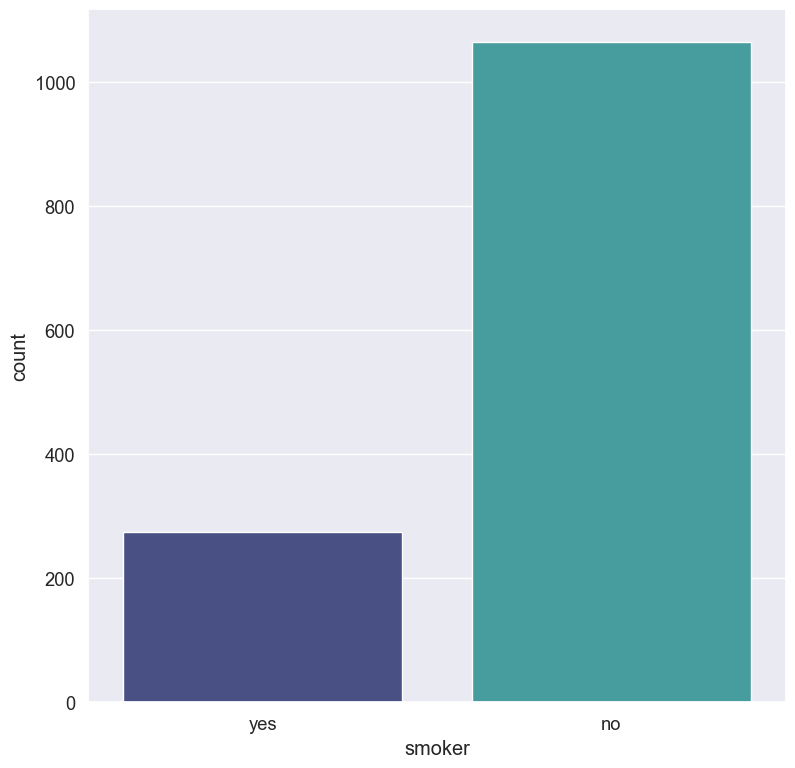

In [4]:
sns.countplot(data = df, x ='smoker',palette='mako')

<Axes: xlabel='smoker', ylabel='count'>

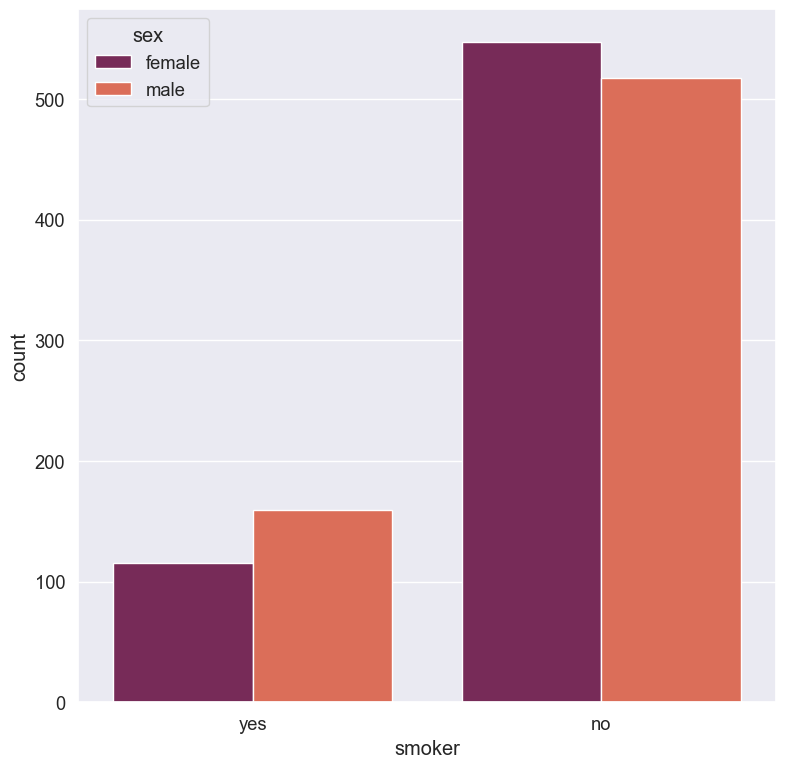

In [5]:
sns.countplot(data = df, x ='smoker',hue='sex',palette='rocket')

<Axes: xlabel='sex', ylabel='count'>

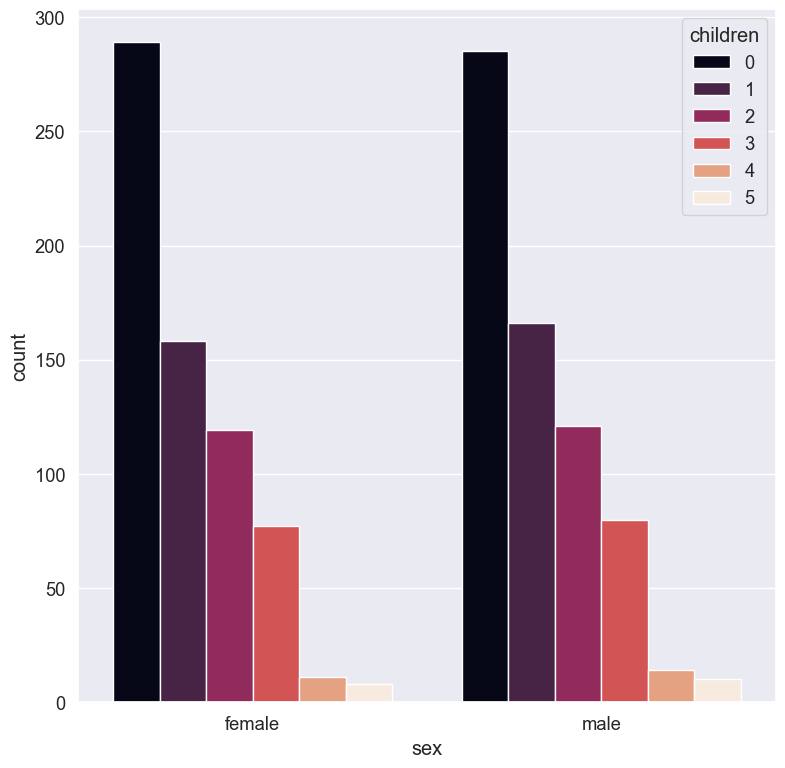

In [6]:
sns.countplot(data = df, x ='sex',hue='children',palette='rocket')

<Axes: xlabel='children', ylabel='count'>

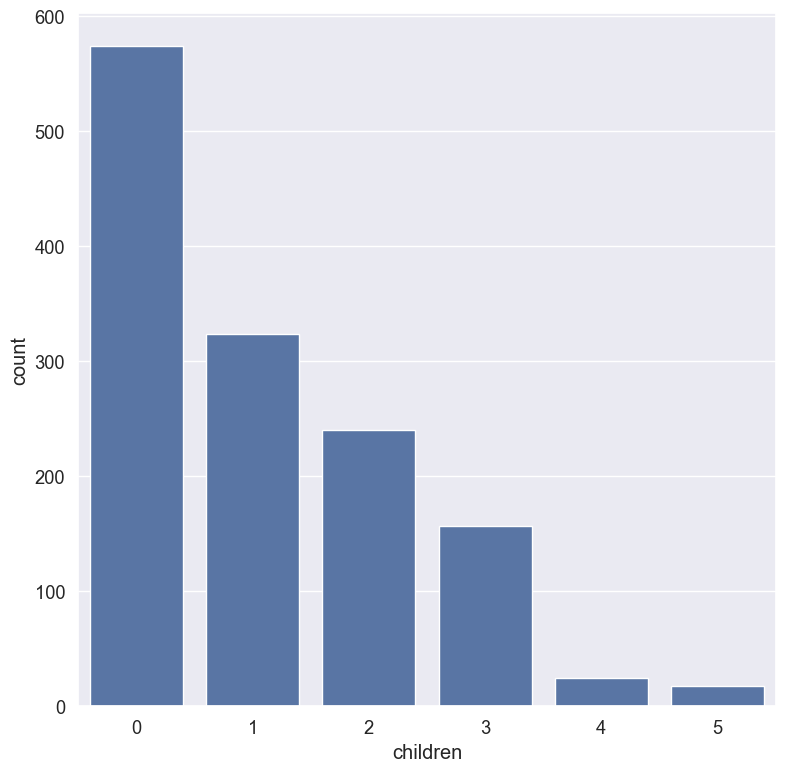

In [7]:
sns.countplot(data=df,x='children')

<Axes: xlabel='expenses', ylabel='Count'>

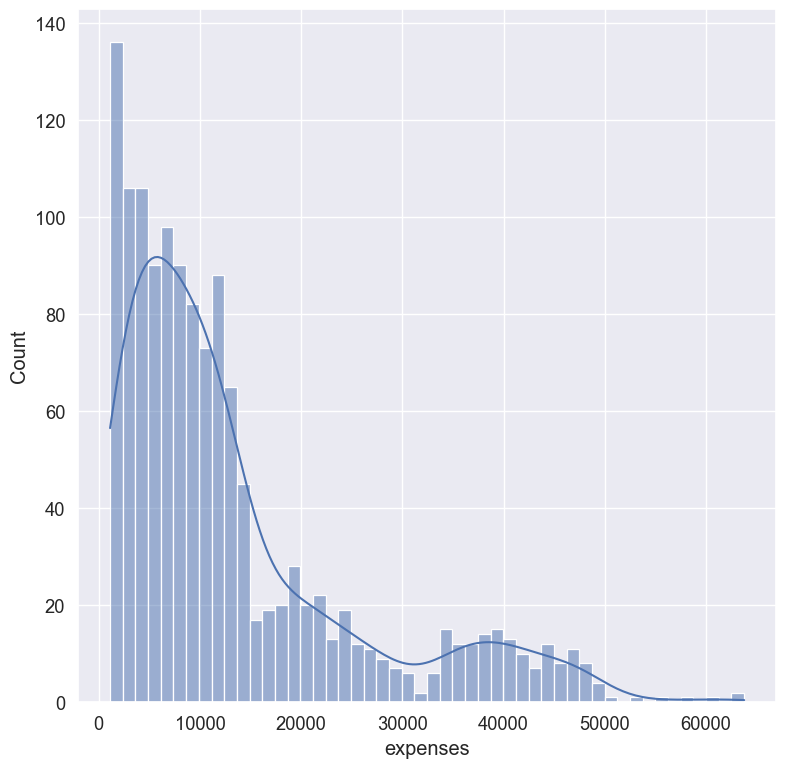

In [8]:
sns.histplot(data=df, x='expenses', bins=50 ,kde=True)

<Axes: xlabel='region', ylabel='count'>

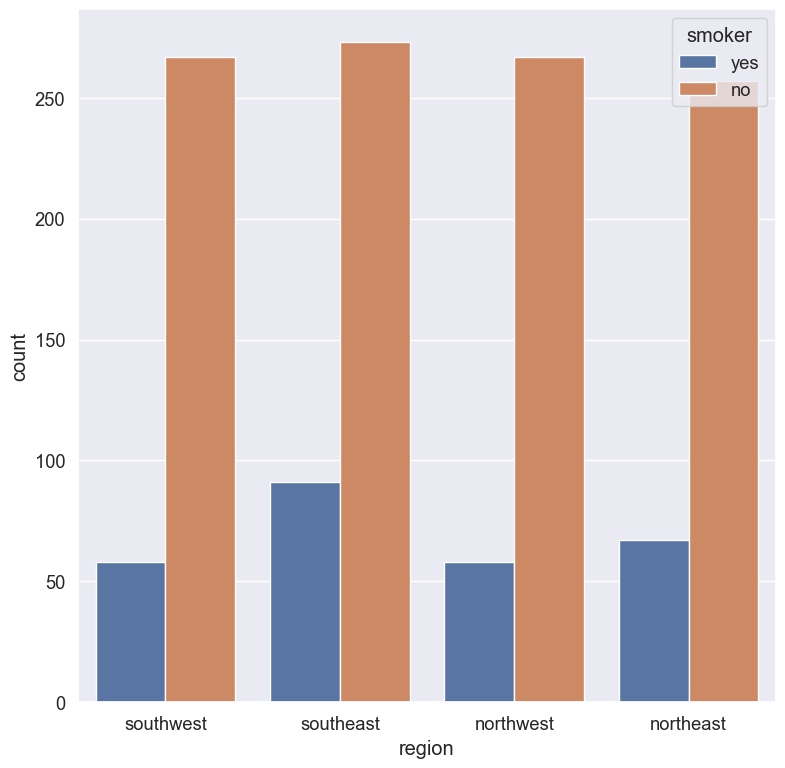

In [9]:
sns.countplot(data=df,x='region',hue='smoker')

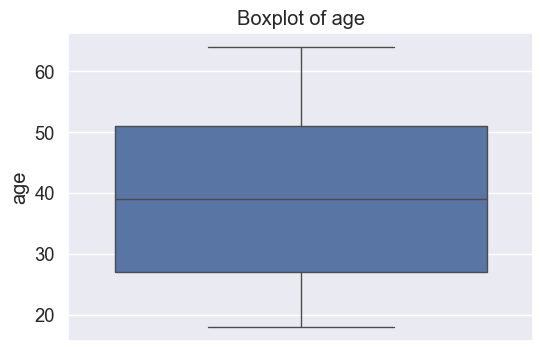

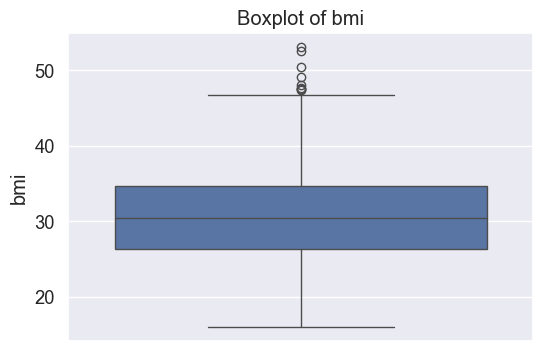

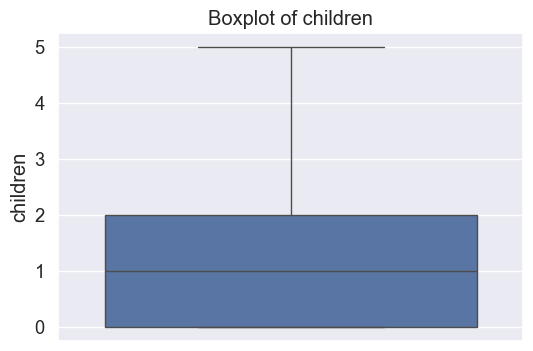

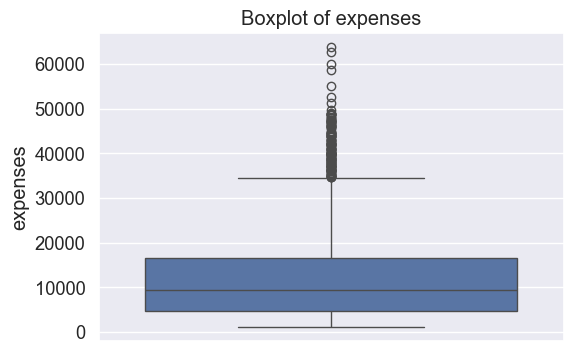

In [10]:
num_df = df.select_dtypes(include=['int64', 'float64']).columns

for column in num_df:
    plt.figure(figsize=(6, 4))  
    sns.boxplot(data=df, y=column)
    plt.title(f'Boxplot of {column}')
    plt.show()

In [11]:
idx = ds.structdata.detect_outliers(df,0,['bmi', 'expenses'])
outliers = df.iloc[idx]
df = df.drop(idx, axis = 0)

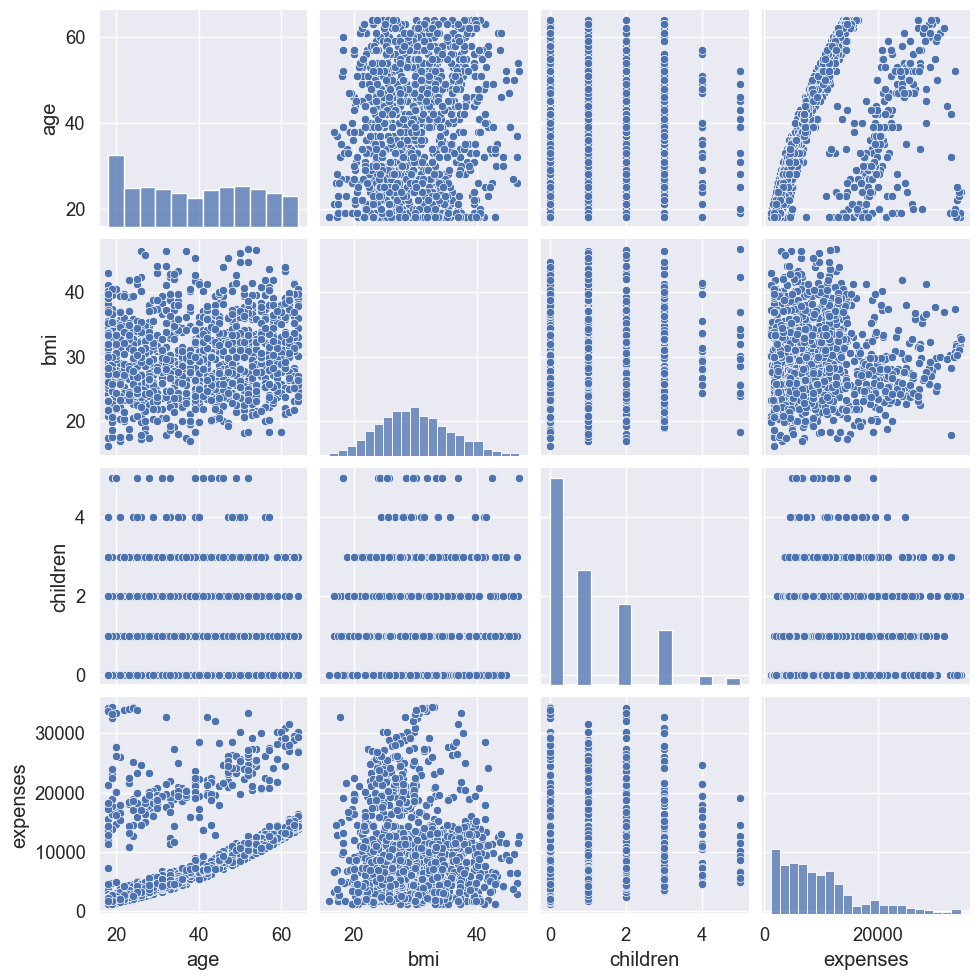

In [12]:
sns.pairplot(data=df)

<Axes: xlabel='region', ylabel='count'>

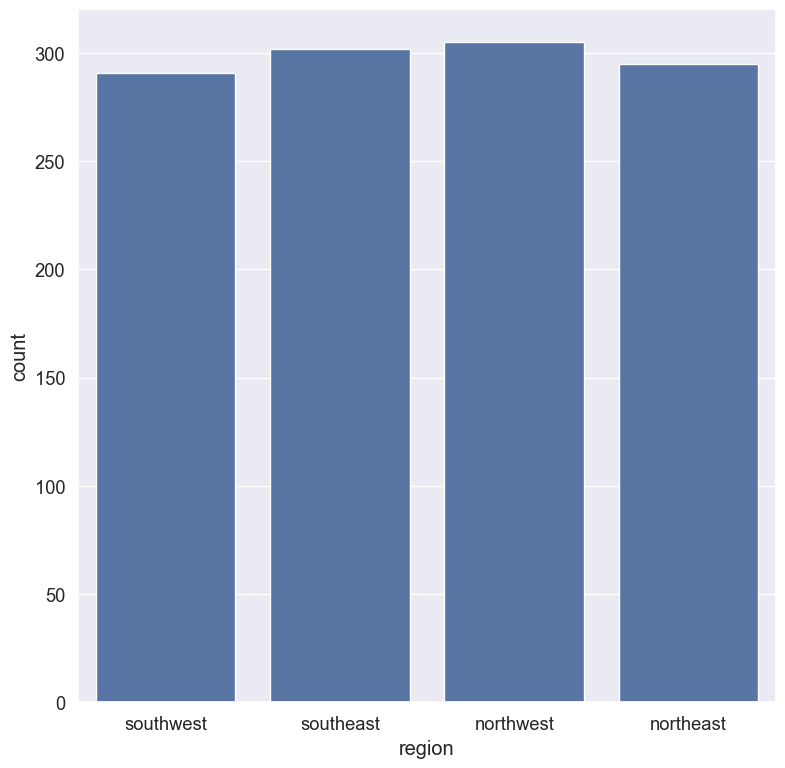

In [13]:
sns.countplot(df,x='region')

<Axes: xlabel='sex', ylabel='count'>

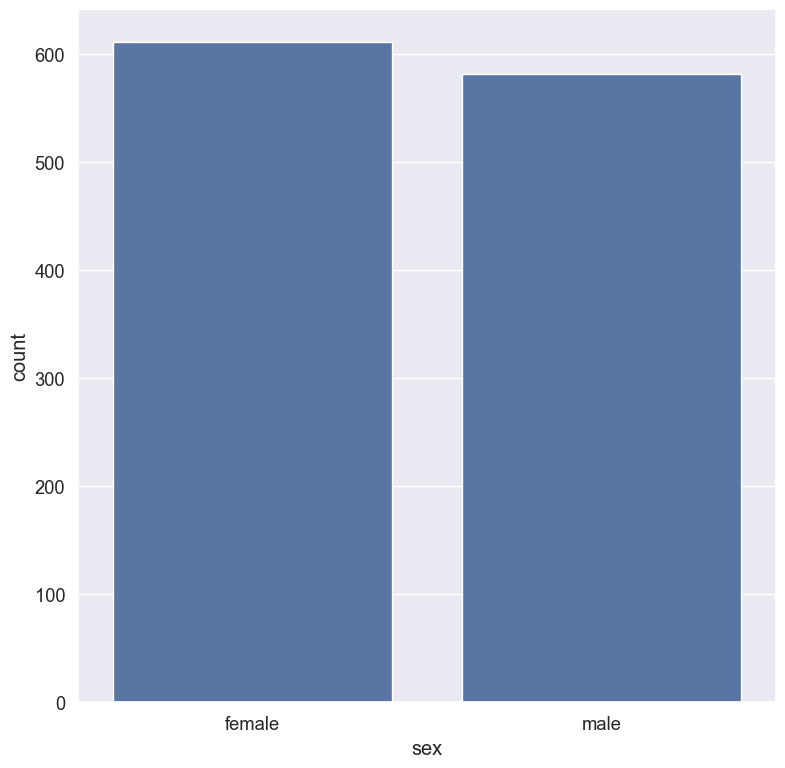

In [14]:
sns.countplot(df,x='sex')

<Axes: >

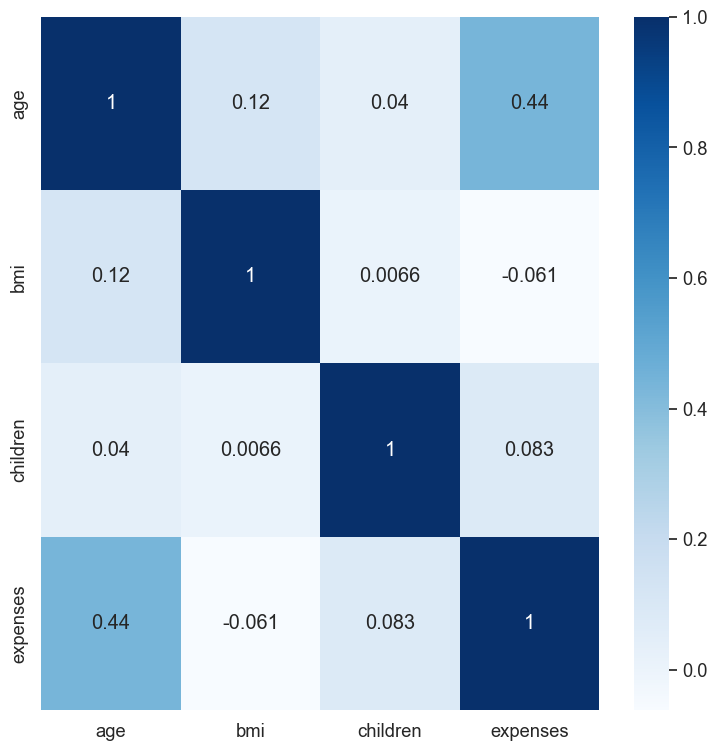

In [15]:
sns.heatmap(df.corr(numeric_only= True), annot=True, cmap= 'Blues')

In [16]:
corr_matrix = df.corr(numeric_only = True)
corr_stacked = corr_matrix.stack()
high_corr_pairs = corr_stacked[(corr_stacked > 0.8) & (corr_stacked < 1.0)]
columns_above_threshold = pd.Index(high_corr_pairs.index.get_level_values(0).unique())

columns_above_threshold

Index([], dtype='object')

## Data Preprocessing

In [17]:
df.isna().any().any()

False

In [18]:
df[df.duplicated()]
df.drop_duplicates(inplace=True)
df

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86
...,...,...,...,...,...,...,...
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95


In [19]:
sex ={
    'female': 0,
    'male': 1
}

smoker = {
    'yes': 1,
    'no': 0
}

In [20]:
df['sex'] = df['sex'].map(sex)
df['smoker'] = df['smoker'].map(smoker)

## Machine Learning

In [21]:
df = pd.get_dummies(df, drop_first=True,dtype=int)
df

,age,sex,bmi,children,smoker,expenses,region_northwest,region_southeast,region_southwest
0,19,0,27.9,0,1,16884.92,0,0,1
1,18,1,33.8,1,0,1725.55,0,1,0
2,28,1,33.0,3,0,4449.46,0,1,0
3,33,1,22.7,0,0,21984.47,1,0,0
4,32,1,28.9,0,0,3866.86,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,1,31.0,3,0,10600.55,1,0,0
1334,18,0,31.9,0,0,2205.98,0,0,0
1335,18,0,36.9,0,0,1629.83,0,1,0
1336,21,0,25.8,0,0,2007.95,0,0,1


In [22]:
x = df.drop(['expenses'],axis = 1)
y = df['expenses']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [23]:
models = {
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Logistic Regression': LinearRegression(n_jobs=1000), 
    'XGBoost': XGBRegressor(eval_metric='mlogloss')  
}

param_grids = {
    'Decision Tree': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [5],
        'min_samples_split': [20],
        'min_samples_leaf': [5]
    },
    'Random Forest': {
        'n_estimators': [40,70],
        'max_depth': [5, 8],
        'min_samples_split': [15],
        'max_features': ['sqrt']
    },
    'Gradient Boosting': {
        'n_estimators': [30, 40],
        'learning_rate': [0.01, 0.03],
        'subsample': [0.8]
    },
    'Logistic Regression': {
        'C': [0.5912, 0.6, 0.61],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    },

    'XGBoost': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6],
        'colsample_bytree': [0.8, 1.0]
    }
}

scalers = {
    'Min-Max Scaler': MinMaxScaler(),
    'Robust Scaler': RobustScaler(),
    'Standard Scaler': StandardScaler()
}

In [35]:
models = {
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Linear Regression': LinearRegression(n_jobs=1000), 
    'XGBoost': XGBRegressor(eval_metric='rmse')  
}

# Define parameter grids for each model
param_grids = {
    'Decision Tree': {
        'criterion': ['squared_error', 'absolute_error'], 
        'max_depth': [5],
        'min_samples_split': [20],
        'min_samples_leaf': [5]
    },
    'Random Forest': {
        'n_estimators': [40, 70],
        'max_depth': [5, 8],
        'min_samples_split': [15],
        'max_features': ['sqrt']
    },
    'Gradient Boosting': {
        'n_estimators': [30, 40],
        'learning_rate': [0.01, 0.03],
        'subsample': [0.8]
    },
    'Linear Regression': {
        'fit_intercept': [True, False]  # Removed 'normalize' parameter
    },
    'XGBoost': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6],
        'colsample_bytree': [0.8, 1.0]
    }
}

best_models = {}
best_params = {}
metrics_results = {}
grid_search_results = {}

for model_name, model in models.items():
    print(f"Running GridSearchCV for {model_name}: ")

    # Adjust scoring for regression
    scoring_metric = 'r2'  # R² is used for GridSearchCV

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        cv=2,
        scoring=scoring_metric,  # R² will be used as the main scoring metric
        verbose=2,
        error_score='raise'
    )
    
    try:
        # Fit the model using GridSearchCV
        grid_search.fit(x_train, y_train)

        # Store the best model, parameters, and score
        best_models[model_name] = grid_search.best_estimator_
        best_params[model_name] = grid_search.best_params_

        # Evaluate the model on the test data
        y_pred = grid_search.predict(x_test)

        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)

        # Store metrics
        metrics_results[model_name] = {
            'R^2': r2,
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse
        }

        # Print the metrics for each model
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        print(f"Metrics for {model_name}:")
        print(f"  R^2: {r2:.4f}")
        print(f"  MAE: {mae:.4f}")
        print(f"  MSE: {mse:.4f}")
        print(f"  RMSE: {rmse:.4f}\n")

        # Store GridSearchCV results
        grid_search_results[model_name] = grid_search.cv_results_

    except Exception as e:
        print(f"Error encountered for {model_name}: {e}\n")

Running GridSearchCV for Decision Tree: 
Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=5, min_samples_split=20; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=5, min_samples_split=20; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=5, min_samples_leaf=5, min_samples_split=20; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=5, min_samples_leaf=5, min_samples_split=20; total time=   0.0s
Best parameters for Decision Tree: {'criterion': 'absolute_error', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 20}
Metrics for Decision Tree:
  R^2: 0.5863
  MAE: 2108.2993
  MSE: 24105907.4244
  RMSE: 4909.7767

Running GridSearchCV for Random Forest: 
Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_split=15, n_estimators=40; total time=   0.0s
[CV] END max_depth=5, max_features=sqr

In [25]:
best_params = {
    'Decision Tree': {'criterion': 'absolute_error', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 20},
    'Random Forest': {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 15, 'n_estimators': 70},
    'Gradient Boosting': {'learning_rate': 0.03, 'n_estimators': 40, 'subsample': 0.8},
    'Linear Regression': {'fit_intercept': True},
    'XGBoost': {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50},
}

results_df = {
    'Model': [],
    'Scaler': [],
    'Train Accuracy': [],
    'Test Accuracy': []
}

models = {
    'Decision Tree': DecisionTreeRegressor(random_state=38, **best_params['Decision Tree']),
    'Random Forest': RandomForestRegressor(random_state=38, **best_params['Random Forest']),
    'Gradient Boosting': GradientBoostingRegressor(random_state=38, **best_params['Gradient Boosting']),
    'Linear Regression': LinearRegression( **best_params['Linear Regression']),
    'XGBoost': XGBRegressor(eval_metric='mlogloss',**best_params['XGBoost'])

}

scalers = {
    'Min-Max Scaler': MinMaxScaler(),
    'Robust Scaler': RobustScaler(),
    'Standard Scaler': StandardScaler()
}

In [26]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils.multiclass import type_of_target

def evaluate_models(models, scalers, x_train, y_train, x_test, y_test):
    results = {model_name: {scaler_name: {'y_true': [], 'y_pred': []} for scaler_name in scalers.keys()} for model_name in models.keys()}
    results_df= {"Model": [], "Scaler": [], "Train R2 Score": [], "Test R2 Score": []}

    for model_name, model in models.items():
        for scaler_name, scaler in scalers.items():
            x_train_scaled = scaler.fit_transform(x_train)
            x_test_scaled = scaler.transform(x_test)

            model.fit(x_train_scaled, y_train)
            y_train_pred = model.predict(x_train_scaled)
            y_test_pred = model.predict(x_test_scaled)

            train_r2 = r2_score(y_train, y_train_pred)
            test_r2 = r2_score(y_test, y_test_pred)

            results_df["Model"].append(model_name)
            results_df["Scaler"].append(scaler_name)
            results_df["Train R2 Score"].append(train_r2)
            results_df["Test R2 Score"].append(test_r2)
            results[model_name][scaler_name]['y_true'] = y_test
            results[model_name][scaler_name]['y_pred'] = y_test_pred

    return results, results_df

def plot_confusion_matrices(results, models, scalers, y_test):
    num_models = len(models)
    num_scalers = len(scalers)

    fig, axes = plt.subplots(num_models, num_scalers, figsize=(20, num_models * 5), constrained_layout=True)

    for i, (model_name, _) in enumerate(models.items()):
        for j, (scaler_name, _) in enumerate(scalers.items()):
            ax = axes[i, j]
            y_true = results[model_name][scaler_name]['y_true']
            y_pred = results[model_name][scaler_name]['y_pred']

results, results_df = evaluate_models(models, scalers, x_train, y_train, x_test, y_test)

In [27]:
pd.DataFrame(results_df)

,Model,Scaler,Train R2 Score,Test R2 Score
0,Decision Tree,Min-Max Scaler,0.641694,0.586266
1,Decision Tree,Robust Scaler,0.641694,0.585926
2,Decision Tree,Standard Scaler,0.641694,0.585926
3,Random Forest,Min-Max Scaler,0.700607,0.587183
4,Random Forest,Robust Scaler,0.700787,0.588393
5,Random Forest,Standard Scaler,0.700894,0.587659
6,Gradient Boosting,Min-Max Scaler,0.602451,0.566483
7,Gradient Boosting,Robust Scaler,0.602460,0.566893
8,Gradient Boosting,Standard Scaler,0.602472,0.567236
9,Linear Regression,Min-Max Scaler,0.601523,0.599947


In [28]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

model = XGBRegressor(colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50)
model.fit(x_train_scaled, y_train)

y_pred = model.predict(x_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R² Score: {r2:.4f}')

Mean Squared Error: 20833774.4179
Mean Absolute Error: 2491.3619
R² Score: 0.6424


### Trails

In [31]:
data1 = np.array(df.iloc[12].tolist()[:-1])
data1

array([2.30000e+01, 1.00000e+00, 3.44000e+01, 0.00000e+00, 0.00000e+00,
       1.82684e+03, 0.00000e+00, 0.00000e+00])

In [32]:
df.iloc[12].tolist()[-1]

1.0

In [34]:
model.predict(scaler.transform([data1]))

array([4055.6885], dtype=float32)